In [32]:
import copy
import pickle
import numpy as NP
# from scipy.spatial import KDTree
import scipy as SP
# from scipy import sparse
from astropy.io import ascii
from astropy import units as U
from astropy import constants as FC
from matplotlib import pyplot as PLT
from astroutils import mathops as OPS

from IPython.core.debugger import set_trace

In [33]:

def rect2DNN_to_ix_(ycornerNN, xcornerNN, ysizeNN, xsizeNN):
    ycornerNN = NP.array(ycornerNN)
    xcornerNN = NP.array(xcornerNN)
    ysizeNN = NP.array(ysizeNN)
    xsizeNN = NP.array(xsizeNN)
    ix_ = [NP.ix_(ycornerNN[i]+NP.arange(ysizeNN[i]), xcornerNN[i]+NP.arange(xsizeNN[i])) if xsizeNN[i]*ysizeNN[i] > 0 else NP.ix_([], []) for i in range(len(xcornerNN))]
    return ix_

def ix_to_unraveled_ind(ixlist):
    ind_list = [(NP.repeat(ix_[0], ix_[1].size, axis=1).ravel(), NP.repeat(ix_[1], ix_[0].size, axis=0).ravel()) for ix_ in ixlist]
    return ind_list

def unraveled_to_raveled(unraveled_ind_list, shape):
    ind_list = [NP.ravel_multi_index(ind, shape) for ind in unraveled_ind_list]
    return ind_list

def grid_to_element_mapping(raveled_ind_list, gridshape):
    gridsize = gridshape[0]*gridshape[1]
    gridcontains = [[] for _ in range(gridsize)]
    for i, sublist in enumerate(raveled_ind_list):
        for value in sublist:
            gridcontains[value].append(i)
    gridcounts = NP.array([len(item) for item in gridcontains])
    return (gridcontains, gridcounts)



# def rect2DNN_old(x_ngbrof, y_ngbrof, x_ngbrin, y_ngbrin, delX=1, delY=1):
#     xofkdt = KDTree(x_ngbrof.reshape(-1,1))
#     yofkdt = KDTree(y_ngbrof.reshape(-1,1))
#     xinkdt = KDTree(x_ngbrin.reshape(-1,1))
#     yinkdt = KDTree(y_ngbrin.reshape(-1,1))
#     indxNN_list = xofkdt.query_ball_tree(xinkdt, delX, p=1)
#     indyNN_list = yofkdt.query_ball_tree(yinkdt, delY, p=1)
#     xsizeNN = [len(indxNN_list[i]) for i in range(x_ngbrof.size)]
#     ysizeNN = [len(indyNN_list[i]) for i in range(y_ngbrof.size)]
#     areaNN = NP.array(xsizeNN) * NP.array(ysizeNN)
#     xcornerNN = [NP.min(indxNN_list[i]) if xsizeNN[i]>0 else None for i in range(x_ngbrof.size)]
#     ycornerNN = [NP.min(indyNN_list[i]) if ysizeNN[i]>0 else None for i in range(y_ngbrof.size)]
#     return (list(zip(ycornerNN, xcornerNN)), list(zip(ysizeNN, xsizeNN)), areaNN)

def rect2DNN(x_ngbrof, y_ngbrof, x_ngbrin, y_ngbrin, delX=1, delY=1):
    dx = x_ngbrin[1] - x_ngbrin[0]
    dy = y_ngbrin[1] - y_ngbrin[0]
    delX_fltind = delX / dx
    delY_fltind = delY / dy
    x_ngbrof_fltind = (x_ngbrof - x_ngbrin.min()) / dx
    y_ngbrof_fltind = (y_ngbrof - y_ngbrin.min()) / dy
    delX_rounded = NP.round(delX_fltind).astype(int)
    delY_rounded = NP.round(delY_fltind).astype(int)
    xsizeNN = NP.clip(delX_rounded, 1, None).astype(int)
    ysizeNN = NP.clip(delY_rounded, 1, None).astype(int)
    xcornerNN = NP.round(x_ngbrof_fltind).astype(int) - xsizeNN//2
    ycornerNN = NP.round(y_ngbrof_fltind).astype(int) - ysizeNN//2
    n_oob_xleft = NP.clip(-xcornerNN, 0, None).astype(int)
    n_oob_xright = NP.clip(xcornerNN-(x_ngbrin.size-1), 0, None).astype(int)
    n_oob_yleft = NP.clip(-ycornerNN, 0, None).astype(int)
    n_oob_yright = NP.clip(ycornerNN-(y_ngbrin.size-1), 0, None).astype(int)
    xsizeNN -= (n_oob_xleft + n_oob_xright)
    ysizeNN -= (n_oob_yleft + n_oob_yright)
    areaNN = NP.array(xsizeNN) * NP.array(ysizeNN)
    xcornerNN = NP.clip(xcornerNN, 0, x_ngbrin.size-1).astype(int)
    ycornerNN = NP.clip(ycornerNN, 0, y_ngbrin.size-1).astype(int)
    return (xcornerNN, ycornerNN, xsizeNN, ysizeNN, areaNN)

# def gaussian2D_kernel(x, y, sigma=1.0):
#     return NP.exp(-(x**2 + y**2) / (2 * sigma**2))

# def rect2D_kernel(x, y, delX=1, delY=1):
#     kernel = NP.zeros(x.shape, dtype=float)
#     select_ind = NP.where(NP.logical_and(NP.abs(x)<=delX, NP.abs(y)<=delY))
#     kernel[select_ind] = 1.0
#     return kernel

In [34]:
def grid(rangelist, pad=None, spacing=None, pow2=True, verbose=True):

    """
    -----------------------------------------------------------------------------
    Produce a multi-dimensional grid.
    
    Inputs:
    rangelist [list of tuples] Each tuple is made of two elements, the min and
              max with min < max. One tuple for each axis.
             
    pad       [Optional. Scalar or list] The padding (in same units as range) to
              be applied along the axes. Default=None implies no padding.
              
    spacing   [Optional. Scalar or list] The spacing for the grid along each of
              the axes. If not supplied, a default of sqrt(max-min) is used. If a
              scalar is supplied, it applies for all axes. A list applies for
              each of the axes.
              
    pow2      [Optional, default=True] If set, the grid produced is a power of 2
              in all axes, which is useful for FFT.
              
    verbose   [Default=True]

    Outputs:

    tupleout  [List of tuples] A 4-element tuple for each axis. The elements in
              each tuple are min, max, lengths, and spacing (which could have
              been modified relative to input). The precise grid points can be
              generated by using numpy's linspace using min, max and lengths.
    -----------------------------------------------------------------------------
    """

    for item in rangelist:
        if item[0] >= item[1]:
            raise ValueError('Data ranges provided not compatible with min < max. Exiting from grid().')

    if pad is None:
        pad = NP.zeros(len(rangelist))
    elif isinstance(pad, (int,float)):
        pad = [pad]
    elif isinstance(pad, NP.ndarray):
        pad = pad.tolist()
    elif not isinstance(pad, list):
        raise TypeError('pad must be set to None, scalar, list or numpy array')
        
    if len(pad) == 1:
        pad = [pad] * len(rangelist)
    elif len(pad) > len(rangelist):
        pad = NP.asarray(pad[:len(rangelist)])
    elif (len(pad) > 1) and (len(pad) < len(rangelist)):
        if verbose is True:
            print('Insufficient paddings provided compared to the number of data ranges.')
            print('Assuming the remaining paddings to be zero.')
        pad += [0.0 for ranges in rangelist[len(pad):]]
    pad = NP.asarray(pad).flatten()
    pad.clip(min(NP.abs(pad))) # Remove any negative values for pad

    if spacing is None:
        if verbose is True:
            print('No spacing provided. Setting defaults to sqrt(max-min)')
            print('Final spacings could be different from defaults assumed.')
        spacing = [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(rangelist))]
    elif isinstance(spacing, (int, float)):
        if verbose is True:
            print('Scalar value for spacing provided. Assuming spacing is identical along all axes.')
        spacing = [spacing] * len(rangelist)
    elif len(spacing) > len(rangelist):
        if verbose is True:
            print('Too many values of spacing provided. Ignoring values for indices beyond the length of data ranges.')
        spacing = NP.asarray(spacing[:len(rangelist)])
    elif (len(spacing) > 1) and (len(spacing) < len(rangelist)):
        if verbose is True:
            print('Insufficient spacings provided compared to the number of data ranges.')
            print('Assuming the remaining spacings to be default spacing.')
            print('Final spacings could be different from defaults assumed.')
        # spacing += [NP.sqrt(ranges[1]-ranges[0]) for ranges in rangelist[len(spacing):]]
        spacing += [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(spacing),len(rangelist))]
    spacing = NP.asarray(spacing).flatten()
    spacing.clip(min(NP.abs(spacing)))

    rangelist = NP.asarray(rangelist)
    lengths = NP.ceil((rangelist[:,1]-rangelist[:,0]+2*pad)/spacing)+1
    lengths = lengths.astype(int)

    for i in range(len(lengths)): 
        if (lengths[i] % 2) == 0: lengths[i] += 1
        # make it odd number of bin edges enclsoing first
        # and last intervals so that the mid-point is one
        # of the bin edges.

    if pow2 is True:
        lengths = 2**NP.ceil(NP.log2(lengths))
        lengths = lengths.astype(int)
        newspacing = (rangelist[:,1]-rangelist[:,0]+2*pad)/(lengths-2)
        offsets = rangelist[:,0]-pad+(lengths-2)*newspacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets-newspacing, rangelist[:,1]+pad+0.5*offsets, lengths, newspacing)) # converts numpy arrays into a list of tuples
    else:
        offsets = rangelist[:,0]-pad+(lengths-1)*spacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets, rangelist[:,1]+pad+0.5*offsets, lengths, spacing)) # converts numpy arrays into a list of tuples
    
    return tupleout


In [35]:
def gen_ant_grid_wts_cube(vusize, raveled_ind_lol, ant_grid_wts_lol):
    nchan = len(raveled_ind_lol)
    npol = 2
    wtsgrid = NP.zeros((nchan,npol,npol,vusize), dtype=complex) # (nchan,npol,npol,nvusize)
    grid_to_antenna_mapping = NP.zeros((nchan, vusize), dtype=int) # (nchan, nvusize)
    histgrid = NP.zeros((nchan, vusize), dtype=int) # (nchan, nvusize)
    for iwl in range(nchan):
        for antind, (ravind, awts) in enumerate(zip(raveled_ind_lol[iwl], ant_grid_wts_lol[iwl])):
            wts_ixind = NP.ix_([iwl], NP.arange(npol), NP.arange(npol), ravind)
            g2a_ixind = NP.ix_([iwl], ravind)
            wtsgrid[wts_ixind] += awts[NP.newaxis,...] # (1,npol,npol,npix)
            grid_to_antenna_mapping[g2a_ixind] = antind + 1 # (1,npix)
            histgrid[g2a_ixind] += 1
    return (wtsgrid, grid_to_antenna_mapping, histgrid)

def gen_grid_Ef_cube(vusize, raveled_ind_lol, grid_Ef_chan_list):
    nchan = len(raveled_ind_lol)
    nruns = grid_Ef_chan_list[0].shape[0]
    nant = len(raveled_ind_lol[0])
    npol = 2
    outunit = grid_Ef_chan_list[0].unit
    outarr = NP.zeros((nruns,nchan,npol,vusize), dtype=complex) * outunit # (nruns, nchan, npol, nvusize)
    for iwl in range(nchan):
        for ii,ravind in enumerate(raveled_ind_lol[iwl]):
            ixind = NP.ix_(NP.arange(nruns), [iwl], NP.arange(npol), ravind)
            outarr[ixind] += grid_Ef_chan_list[iwl][:,ii,:,:][:,NP.newaxis,...] # (nruns,1,npol,npix)
    return outarr

def gen_image(inparr, fftshape=None, fftaxes=(-2,-1), polaxis=-4, freqaxis=-3, bwsyn=False):
    polaxis = (polaxis+inparr.ndim) % inparr.ndim
    freqaxis = (freqaxis+inparr.ndim) % inparr.ndim
    outarr = SP.fft.fft2(inparr, s=fftshape, axes=fftaxes)
    outarr = NP.expand_dims(outarr, axis=polaxis) * NP.expand_dims(outarr, axis=polaxis+1).conj()
    if bwsyn:
        outarr = NP.sum(outarr, axis=freqaxis, keepdims=True)
    outarr = SP.fft.fftshift(outarr, axes=fftaxes)
    return outarr

In [36]:
def stochastic_E_spectrum(freq_center, nchan, channel_width, flux_ref=1.0,
                          freq_ref=None, spectral_index=0.0, skypos=None, 
                          ref_point=None, antpos=[0.0,0.0,0.0], nruns=1, 
                          voltage_pattern=None, verbose=True):

    """
    ----------------------------------------------------------------------------
    Compute a stochastic electric field spectrum obtained from sources with 
    given flux densities and spectral indices at given positions at specified 
    antenna locations. 

    Inputs:

    freq_center      [float] Center frequency in Hz. Center frequency must be
                     greater than half the bandwidth.

    nchan            [integer] Number of frequency channels in spectrum

    channel_width    [float] Channel width 

    Keyword Inputs:

    flux_ref         [list or numpy array of float] Flux densities of sources
                     at the respective reference frequencies. Units are 
                     arbitrary. Values have to be positive. Default = 1.0. 

    freq_ref         [list or numpy array of float] Reference frequency (Hz). 
                     If not provided, default is set to center frequency given
                     in freq_center for each of the sources. If a single value 
                     is provided, it will be applicable to all the sources. If a 
                     list or numpy array is provided, it should be of size equal
                     to that of flux_ref. 

    spectral_index   [list or numpy array of float] Spectral Index 
                     (flux ~ freq ** alpha). If not provided, default is set to 
                     zero, a flat spectrum, for each of the sources. If a single 
                     value is provided, it will be applicable to all the sources. 
                     If a list or numpy array is provided, it should be of size 
                     equal to that of flux_ref. 

    skypos           [list, tuple, list of lists, list of tuples, numpy array]
                     Sky positions of sources provided in direction cosine
                     coordinates aligned with local ENU axes. It should be a
                     3-element list, a 3-element tuple, a list of 3-element
                     lists, list of 3-element tuples, or a 3-column numpy array.
                     Each 3-element entity corresponds to a source position. 
                     Number of 3-element entities should equal the number of 
                     sources as specified by the size of flux_ref. Rules of 
                     direction cosine quantities should be followed. If only 
                     one  source is specified by flux_ref and skypos is not
                     specified, skypos defaults to the zenith (0.0, 0.0, 1.0)

    ref_point        [3-element list, tuple, or numpy vector] Point on sky used
                     as a phase reference. Same units as skypos (which is
                     direction cosines and must satisfy rules of direction
                     cosines). If None provided, it defaults to zenith
                     (0.0, 0.0, 1.0)

    antpos           [list, tuple, list of lists, list of tuples, numpy array]
                     Antenna positions provided along local ENU axes. 
                     It should be a 3-element list, a 3-element tuple, a list of 
                     3-element lists, list of 3-element tuples, or a 3-column 
                     numpy array. Each 3-element entity corresponds to an
                     antenna position. If not specified, antpos by default is 
                     assigned the origin (0.0, 0.0, 0.0).

    voltage_pattern  [numpy array] Voltage pattern for each frequency channel
                     at each source location for each antenna. It must be of
                     shape nsrc x nchan x nant. If any of these dimensions are
                     1, it is assumed to be identical along that direction. 
                     If specified as None (default), it is assumed to be unity
                     and identical across antennas, sky locations and frequency
                     channels. 

    verbose:         [boolean] If set to True, prints progress and diagnostic
                     messages. Default = True.
    
    Output:

    dictout          [dictionary] Consists of the following tags and info:
                     'f'        [numpy array] frequencies of the channels in the 
                                spectrum of size nchan
                     'Ef'       [complex numpy array] (nruns, nant, nchan, npol)  
                                numpy array consisting of complex stochastic 
                                electric field spectra. nchan is the number of  
                                channels in the spectrum and nant is the number 
                                of antennas.
                     'antpos'   [numpy array] 3-column array of antenna
                                positions (same as the input argument antpos)

    ----------------------------------------------------------------------------
    """

    nsrc = flux_ref.size
    nant = antpos.shape[0]
    npol = 2
    if voltage_pattern is None:
        voltage_pattern = NP.diag(NP.ones(2))[NP.newaxis,NP.newaxis,NP.newaxis,NP.newaxis,...]
    vb_shape = voltage_pattern.shape

    freqs = freq_center + channel_width * (NP.arange(nchan) - nchan//2)
    if spectral_index is None:
        spectral_index = NP.zeros((1,1,1,1,1))
    alpha = spectral_index.reshape(-1,1,1,1,1)
    freqs = freqs.reshape(1,1,1,-1,1)
    freq_ratio = freqs / freq_ref
    flux_spectra = flux_ref.reshape(nsrc,1,1,1,1) * (freq_ratio ** alpha)
    sigmas = NP.sqrt(flux_spectra)
    Ef_amp = sigmas/NP.sqrt(2) * (NP.random.normal(loc=0.0, scale=1.0, size=(nsrc,nruns,1,nchan,npol)) + 1j * NP.random.normal(loc=0.0, scale=1.0, size=(nsrc,nruns,1,nchan,npol)))
    Ef_phase = 1.0
    Ef_sky = Ef_amp * Ef_phase

    skypos_dot_antpos = NP.dot(skypos-ref_point, antpos.T) # (nsrc, nant)
    k_dot_r_phase = 2.0 * NP.pi * freqs / FC.c * skypos_dot_antpos[:,NP.newaxis,:,NP.newaxis,NP.newaxis] # (nsrc, nant, nchan)
    Ef_ant = NP.einsum('i...mn,i...n->...m', voltage_pattern, Ef_sky * NP.exp(1j * k_dot_r_phase)) # (nruns, nant, nchan, npol)
    if verbose:
        print('Performed linear superposition of electric fields from source(s).')
    dictout = {}
    dictout['f'] = freqs.ravel()
    dictout['Ef'] = Ef_ant # (nruns, nant, nchan, npol)
    dictout['antpos'] = antpos

    if verbose:
        print('stochastic_E_spectrum() executed successfully.\n')

    return dictout


In [37]:
def array_element_grouping(xcorner, ycorner, nblocks=8):

    nelements, nchan = xcorner.shape
    nelements_per_block = nelements // nblocks
    nelements_per_group = nblocks
    ngroups_per_frame = nelements // nelements_per_group
    array_grouping = NP.zeros((nchan,ngroups_per_frame,nelements_per_group), dtype=NP.int32)

    for chan in range(nchan):
        # Sort by y, then by x coordinate
        sorted_y_indexes = NP.argsort(ycorner[:,chan] * 1000 + xcorner[:,chan])
        element_by_block = NP.zeros((nblocks, nelements_per_block))
        element_by_block_x = NP.zeros((nblocks, nelements_per_block))
        element_by_block_sorted = []
        for block in range(nblocks):
            for ant in range(nelements_per_block):
                # element number in each of the blocks
                element_by_block[block,ant] = sorted_y_indexes[block*nelements_per_block + ant]
                # x coordinate of the element in each block
                element_by_block_x[block,ant] = xcorner[sorted_y_indexes[block*nelements_per_block + ant],chan]
            # sort element_by_block according to element_by_block_x, 
            # so that we have elements in the order they will be used in each block
            x_sort_order = NP.argsort(element_by_block_x[block,:])
            element_by_block_sorted.append(list(element_by_block[block,x_sort_order]))

        # Create an array with dimensions (Ng=nelements_per_block groups)x(Na/g=nblocks elements per group) which contains the element numbers.
        for group in range(ngroups_per_frame):
            # Make Ng=nelements_per_block groups, with Na/g=nblocks antennas in each group. 
            # The Na/g antennas have one drawn from each block of nelements_per_block antennas
            array_grouping[chan,group,0] = int(element_by_block_sorted[0][0])
            element_by_block_sorted[0].remove(array_grouping[chan,group,0])
            for block in range(1,nelements_per_group):
                # Make sure the element doesn't have the same y coordinate as the element selected in the previous block
                group_i = 0
                for c in range(nchan):
                    while (ycorner[array_grouping[chan,group,block-1],c] == ycorner[int(element_by_block_sorted[block][group_i]),c]):
                        group_i += 1
                array_grouping[chan,group,block] = int(element_by_block_sorted[block][group_i])
                element_by_block_sorted[block].remove(array_grouping[chan,group,block])

    return array_grouping

In [38]:
def load_FIFO(array_element_groups, elements_to_grid_mapping_unraveled_lol, xcorner, ycorner, nFIFO=64):
    nchan, ngroups_per_word, nelements_per_group = array_element_groups.shape
    output = -1 + NP.zeros((nchan, ngroups_per_word, nFIFO, 2), dtype=int)
    ncols = nFIFO
    for chan in range(nchan):
        for group_ind in range(ngroups_per_word):
            elements_in_group = array_element_groups[chan,group_ind,:]
            rows_of_elements = []
            elements_in_FIFOs = []
            for element in elements_in_group:
                # rows, cols = NP.unravel_index(elements_to_grid_mapping_unraveled_lol[chan][element], shape=(nFIFO,nFIFO))
                rows, cols = elements_to_grid_mapping_unraveled_lol[chan][element]
                unique_rows = NP.unique(rows)
                rows_of_elements.append(unique_rows)
                elements_in_FIFOs.append(element+NP.zeros(unique_rows.size, dtype=int))
            rows_of_elements = NP.array(rows_of_elements, dtype=int).ravel()
            elements_in_FIFOs = NP.array(elements_in_FIFOs, dtype=int).ravel()
            bincount, binedges, binnum, ri = OPS.binned_statistic(NP.array(rows_of_elements), statistic='count', bins=list(range(nFIFO+1)))
            bincount = bincount.astype(int)
            for iFIFO in range(nFIFO):
                if bincount[iFIFO] > 0:
                    ind = ri[ri[iFIFO]:ri[iFIFO+1]]
                    elements_in_FIFO_i = elements_in_FIFOs[ind]
                    if bincount[iFIFO] == 1:
                        output[chan,group_ind,iFIFO,0] = elements_in_FIFO_i[0]
                    elif bincount[iFIFO] == 2:
                        ind_sorted_xcorner = NP.argsort(xcorner[elements_in_FIFO_i,chan])
                        output[chan,group_ind,iFIFO,:] = elements_in_FIFO_i[ind_sorted_xcorner]
                    else:
                        raise ValueError('More than two elements need to be stored in two clock cycles. FIFO conflict!')
    return output.astype(int)

In [39]:
# def nearest_nghbrs(input_locations, grid_x, grid_y, distUL, dist_norm=2.0, workers=1):
#     # Create a grid of 2D x and y locations
#     grid_points = NP.column_stack((grid_x.flatten(), grid_y.flatten()))

#     # Build KDTree using grid locations
#     kdt = KDTree(grid_points)
#     list_indNN = kdt.query_ball_point(input_locations, distUL, p=dist_norm, 
#                                       eps=0, workers=1, return_sorted=None, 
#                                       return_length=False)
#     return list_indNN

# def gridder(input_locations, input_values, grid_x, grid_y, kernel_func, dist_norm=2.0, workers=1):
#     list_indNN = nearest_nghbrs(input_locations, grid_x, grid_y, dist_norm=dist_norm, workers=workers)
#     result_grid = NP.zeros_like(grid_x, dtype=float)
#     for input_loc, input_val in zip(input_locations, input_values):
#         # Find nearest grid locations using KDTree
#         if distance_metric == 'l2':
#             _, nearest_indices = kdt.query(input_loc, k=4)  # You can adjust 'k' based on your requirements
#         elif distance_metric == 'manhattan':
#             _, nearest_indices = kdt.query(input_loc, k=4, p=1)
#         else:
#             raise ValueError("Invalid distance metric. Use 'l2' or 'manhattan'.")

#         # Calculate distances and kernel weights
#         distances = NP.linalg.norm(grid_points[nearest_indices] - input_loc, axis=1)
#         weights = kernel_func(*NP.transpose(distances))

#         # Normalize weights
#         weights /= NP.sum(weights)

#         # Extrapolate input value onto grid locations
#         result_grid += NP.sum(weights[:, NP.newaxis, NP.newaxis] * input_val, axis=0).reshape(result_grid.shape)

#     return result_grid

In [46]:
fc = 100*U.MHz
df = 100 * U.kHz
nchan = 1
duration = 1000*U.ms
bw = nchan * df
freqs = fc + df * (NP.arange(nchan) - nchan//2)
# freqs = NP.array(freqs).reshape(-1)
wl = (FC.c / freqs).to(U.m)
delT = (1/df).to(U.s)
dt = (1/bw).to(U.s)
nruns = NP.round((duration/delT).decompose()).astype(int)

In [47]:
print(duration)
print(delT)
print(nruns)
print(freqs.shape)

1000.0 ms
1e-05 s
100000
(1,)


In [48]:
datadir = '/mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/'
# datadir = '/home/hum089/projects/epic/jupyter/data/'
# aavs_antlocs_file = 'AAVS2_loc_italia_190429.txt'
aavs_antlocs_file = 'AAVS2_loc_italia_190429_modified.txt'
anttab = ascii.read(datadir+aavs_antlocs_file, names=['id', 'x', 'y', 'z'], format='no_header')
anttab['id'] = anttab['id'].astype(int)
anttab['x'] = anttab['x'] * U.m
anttab['y'] = anttab['y'] * U.m
anttab['z'] = anttab['z'] * U.m
nants = anttab['id'].size
antx = anttab['x']
anty = anttab['y']
antz = anttab['z']
antx = antx - NP.mean(antx) * anttab['x'].unit
anty = anty - NP.mean(anty) * anttab['y'].unit
antz = antz - NP.mean(antz) * anttab['z'].unit

In [49]:
anttab.pprint()

 id   x      y    z  
      m      m    m  
--- ------ ----- ----
  1  17.47 -6.81 15.0
  2   17.7 -3.94 16.0
  3  18.89 -1.21 16.0
  4  18.11  1.02 16.0
  5  17.92  3.28 16.0
  6  15.75  8.85  5.0
  7  15.85  6.68  5.0
  8  16.94  5.18  5.0
  9  15.17 -0.69 16.0
 10  16.19 -1.99 16.0
...    ...   ...  ...
247 -16.08  4.29  9.0
248 -17.09  5.57  9.0
249  -15.4  6.96  9.0
250 -16.04 10.18  9.0
251 -17.32  7.53  9.0
252 -18.67  3.36  9.0
253 -18.51  1.41 10.0
254 -18.26 -0.33 10.0
255 -17.35 -3.38 10.0
256  -17.6 -6.37 11.0
Length = 256 rows


In [50]:
au = antx.reshape(-1,1) / wl.reshape(1,-1)
av = anty.reshape(-1,1) / wl.reshape(1,-1)
aw = antz.reshape(-1,1) / wl.reshape(1,-1)
au_min = au.min()
av_min = av.min()
aw_min = aw.min()
au_max = au.max()
av_max = av.max()
aw_max = aw.max()
print(au_min, av_min, aw_min)
print(au_max, av_max, aw_max)

-6.113604432303631 -6.282275807785666 -2.5017307139861407
6.415062983338961 6.283083658328723 2.5017307139861407


In [51]:
print(anttab['z'].min(), anttab['z'].max())
print(NP.mean(anttab['x']))
print(NP.mean(anttab['y']))
print(NP.mean(anttab['z']))
print(antx.shape)

1.0 16.0
-0.34187499999999993
-0.08621093750000006
8.5
(256,)


In [52]:
print(au.min(), au.max())
print(av.min(), av.max())

-6.113604432303631 6.415062983338961
-6.282275807785666 6.283083658328723


In [53]:
sizex_ant = 1.64 * U.m
sizey_ant = 1.64 * U.m 
ant_sampling_factor = 2.0
upad = sizex_ant / wl.min()
vpad = sizey_ant / wl.min()
du_ant = sizex_ant / (ant_sampling_factor * wl.max())
dv_ant = sizey_ant / (ant_sampling_factor * wl.max())
ant_uvec_info, ant_vvec_info = grid([(au_min,au_max), (av_min,av_max)], pad=[upad, vpad], spacing=[du_ant, dv_ant], pow2=True)
ant_uvec = NP.linspace(ant_uvec_info[0], ant_uvec_info[1], num=ant_uvec_info[2], endpoint=True)
ant_vvec = NP.linspace(ant_vvec_info[0], ant_vvec_info[1], num=ant_vvec_info[2], endpoint=True)
ant_ugrid, ant_vgrid = NP.meshgrid(ant_uvec, ant_vvec)
print(ant_ugrid.shape)


(64, 64)


In [54]:
nsrc = 4
flux_ref = (1.0+NP.arange(nsrc))*U.Jy
skypos = NP.array([[0.0, 0.0, 1.0], 
                   [0.5, 0.0, NP.sqrt(3.0)/2],
                   [0.0, -0.5, NP.sqrt(3.0)/2],
                   [-0.5, 0.5, NP.sqrt(1.0)/2],
                   ])
ref_point= NP.array([[0.0, 0.0, 1.0]])
antpos = NP.hstack([antx.reshape(-1,1), anty.reshape(-1,1), antz.reshape(-1,1)])
ant_E_dynspec = stochastic_E_spectrum(fc, nchan, df, flux_ref, freq_ref=fc, 
                                      spectral_index=None, skypos=skypos, 
                                      ref_point=ref_point, antpos=antpos, 
                                      nruns=nruns, voltage_pattern=None)

Performed linear superposition of electric fields from source(s).
stochastic_E_spectrum() executed successfully.



In [55]:
print(ant_E_dynspec['Ef'].shape)

(100000, 256, 1, 2)


In [56]:
ix_list = []
unraveled_ind_lol = []
raveled_ind_lol = []
ant_grid_wts_lol = []
grid_to_ant_mapping_lol = []
delX = (NP.zeros((nants,1))+sizex_ant/wl.reshape(1,-1)).ravel()
delY = (NP.zeros((nants,1))+sizey_ant/wl.reshape(1,-1)).ravel()
xcornerNN, ycornerNN, xsizeNN, ysizeNN, areaNN = rect2DNN(au.ravel(), av.ravel(), ant_uvec, ant_vvec, delX=delX, delY=delY)
xcornerNN = xcornerNN.reshape(nants, -1)
ycornerNN = ycornerNN.reshape(nants, -1)
xsizeNN = xsizeNN.reshape(nants, -1)
ysizeNN = ysizeNN.reshape(nants, -1)
areaNN = areaNN.reshape(nants, -1)
grid_histograms = []
for iwl in range(wl.size):    
    ix_ = rect2DNN_to_ix_(ycornerNN[:,iwl], xcornerNN[:,iwl], ysizeNN[:,iwl], xsizeNN[:,iwl])
    ix_list += [copy.deepcopy(ix_)]
    unraveled_ind = ix_to_unraveled_ind(ix_)
    unraveled_ind_lol += [copy.deepcopy(unraveled_ind)]
    raveled_ind = unraveled_to_raveled(unraveled_ind, ant_ugrid.shape)    
    raveled_ind_lol += [copy.deepcopy(raveled_ind)]
    ant_grid_wts = [NP.diag(NP.ones(2))[...,NP.newaxis]*NP.ones((1,1,len(item))) for item in raveled_ind]
    ant_grid_wts_lol += [copy.deepcopy(ant_grid_wts)]
    gridcontains, gridcounts = grid_to_element_mapping(raveled_ind, ant_ugrid.shape)
    grid_to_ant_mapping_lol += [copy.deepcopy(gridcontains)]
    grid_histograms += [copy.deepcopy(gridcounts)]
grid_histograms = NP.array(grid_histograms)


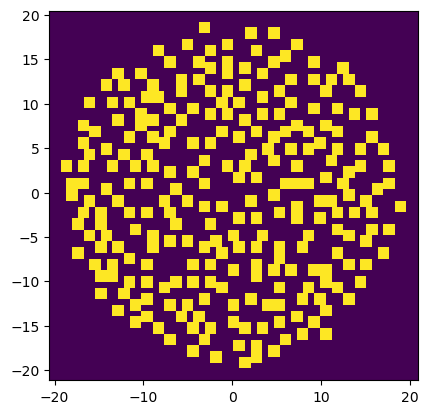

In [57]:
overlap_locations = NP.where(grid_histograms > 1)
for chan,overlap in zip(overlap_locations[0],overlap_locations[1]):
    print(chan, overlap)
    print(grid_to_ant_mapping_lol[chan][overlap])
    # print(grid_to_ant_mapping_lol[overlap])
# overlaps = NP.where(grid_histograms[select_chan]>1)[0]
# overlaps = NP.ravel_multi_index(overlaps, ant_ugrid.shape)

select_chan = 0
fig = PLT.figure()
ax = fig.add_subplot(111)
# ax.imshow(grid_histograms[select_chan].reshape(ant_ugrid.shape), extent=[ant_uvec.min(), ant_uvec.max(), ant_vvec.min(), ant_vvec.max()], interpolation='none')
# ax.imshow(grid_histograms[select_chan].reshape(ant_ugrid.shape)[::-1,:], extent=[antx.value.min(), antx.value.max(), anty.value.min(), anty.value.max()], interpolation='none')
ax.imshow(grid_histograms[select_chan].reshape(ant_ugrid.shape), origin='lower', extent=[ant_uvec.min()*wl.value.max(), ant_uvec.max()*wl.value.max(), ant_vvec.min()*wl.value.max(), ant_vvec.max()*wl.value.max()], interpolation='none')
# ax.imshow(grid_histograms[select_chan].reshape(ant_ugrid.shape), interpolation='none')
# for ia in range(nants):
#     ax.text(au[ia,select_chan], av[ia,select_chan], '{:0d}'.format(ia), color='white', fontsize=8)

In [58]:
grid_wts_cube, grid_to_antenna_mapping, gridhist = gen_ant_grid_wts_cube(ant_ugrid.size, raveled_ind_lol, ant_grid_wts_lol)

In [59]:
print(ant_grid_wts_lol[0][0].shape)

(2, 2, 4)


In [61]:
NP.savez_compressed(datadir+'epic-test-data-{0:0d}-runs-{1:0d}x{2:0d}-grid-{3:0d}-ants-{4:0d}-chans.npz'.format(nruns, ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), ant_Etafp=ant_E_dynspec['Ef'].to('Jy(1/2)').value, antpos=NP.hstack([antx.reshape(-1,1),anty.reshape(-1,1),antz.reshape(-1,1)]), freqs=freqs.to('MHz').value, xcorners=xcornerNN, ycorners=ycornerNN, xsizes=xsizeNN, ysizes=ysizeNN)
print('NPZ file saved at: '+datadir+'epic-test-data-{0:0d}-runs-{1:0d}x{2:0d}-grid-{3:0d}-ants-{4:0d}-chans.npz'.format(nruns, ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan))

NPZ file saved at: /mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/epic-test-data-100000-runs-64x64-grid-256-ants-1-chans.npz


In [62]:
with open(datadir+'epic-test-ant-wts-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.pkl'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), 'wb') as fobj:
    pickle.dump(ant_grid_wts_lol, fobj)

In [63]:
npol = 2
nri = 2
nbytes_per_sample = 1
print(nchan*nruns*nants*npol*nri*nbytes_per_sample/2**30) # in GB

0.095367431640625


In [29]:
# distUL = 3.0
# xv = NP.arange(12)
# yv = NP.arange(16)
# xg, yg = NP.meshgrid(xv, yv)
# xlocs = NP.array([2.5, 5.2, 8.6])
# ylocs = NP.array([3.5, 9.2, 6.9])
# xgrel = xg.ravel()[NP.newaxis,...] - xlocs[:,NP.newaxis]
# ygrel = yg.ravel()[NP.newaxis,...] - ylocs[:,NP.newaxis]
# layered_rectkern = rect2D_kernel(xgrel, ygrel, delX=2, delY=2)
# # layered_rectkern = gaussian2D_kernel(xgrel, ygrel, sigma=1)   
# layered_rectkern = layered_rectkern.reshape(xlocs.shape+xg.shape) 
# valgrid = NP.sum(NP.ones(xlocs.shape, dtype=float).reshape(-1,1,1) * layered_rectkern, axis=0)
# print(valgrid)

1.0


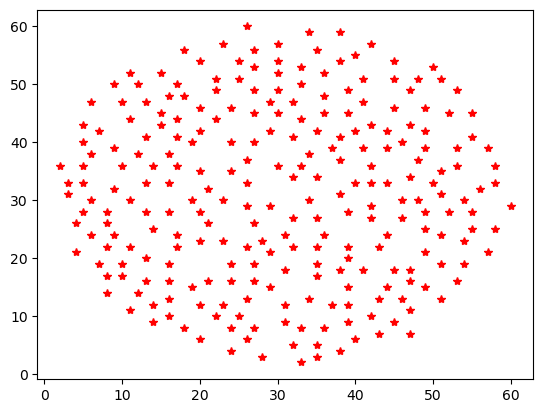

In [64]:
#print((nchan,nruns,nants))
# print(ant_E_dynspec['Ef'].shape)
# print(ant_E_dynspec['Ef'][0:10,0,0,0])
# print(NP.max(ant_E_dynspec['Ef'][:,0,0,0]))
#print(ant_grid_wts_lol[0][0])

p_used = NP.zeros((ant_ugrid.shape[0],ant_ugrid.shape[1],nchan))
for c in range(nchan):
    for p in range(nants):
        if p_used[xcornerNN[p,c],ycornerNN[p,c],c]:
            print(f"duplicate : channel {c} p = {p}, x,y = {xcornerNN[p,c]},{ycornerNN[p,c]}")
        p_used[xcornerNN[p,c],ycornerNN[p,c],c] = p_used[xcornerNN[p,c],ycornerNN[p,c],c] + 1
print(NP.max(p_used))
fig = PLT.figure()
ax = fig.add_subplot(111)
ax.plot(xcornerNN[:,0],ycornerNN[:,0],'r*')


In [65]:
print(xcornerNN[100:110,:])

[[35]
 [36]
 [35]
 [35]
 [35]
 [37]
 [36]
 [35]
 [35]
 [33]]


y destinations:
[[11. 19. 21. 31. 36. 40. 47. 50.]
 [ 9. 14. 24. 26. 33. 43. 47. 52.]
 [12. 17. 22. 28. 36. 38. 44. 50.]
 [10. 19. 24. 30. 33. 42. 47. 52.]
 [ 8. 17. 22. 28. 32. 39. 45. 50.]
 [ 6. 14. 20. 26. 36. 38. 48. 56.]
 [12. 16. 25. 30. 33. 41. 44. 54.]
 [10. 13. 22. 28. 36. 43. 48. 51.]
 [12. 16. 24. 28. 33. 38. 46. 57.]
 [ 8. 19. 23. 30. 36. 41. 44. 54.]
 [ 4. 15. 23. 28. 35. 40. 49. 51.]
 [10. 16. 19. 26. 32. 42. 46. 60.]
 [ 6. 16. 22. 30. 35. 40. 45. 56.]
 [ 8. 13. 19. 29. 37. 40. 49. 53.]
 [ 3. 16. 23. 26. 33. 42. 47. 52.]
 [12. 15. 21. 29. 36. 41. 45. 57.]
 [ 9. 18. 24. 27. 34. 38. 49. 54.]
 [ 5. 13. 22. 30. 36. 42. 47. 53.]
 [ 2. 17. 22. 27. 34. 39. 44. 50.]
 [ 8. 18. 19. 28. 31. 41. 48. 59.]
 [ 5. 15. 24. 29. 33. 37. 45. 56.]
 [ 3. 12. 20. 27. 33. 42. 45. 52.]
 [ 8. 18. 22. 27. 36. 39. 49. 59.]
 [12. 13. 22. 30. 33. 39. 47. 54.]
 [ 4. 15. 24. 30. 34. 42. 43. 55.]
 [ 9. 18. 25. 28. 33. 40. 46. 51.]
 [ 6. 13. 21. 28. 31. 37. 43. 57.]
 [10. 16. 19. 30. 35. 39. 49. 51.]
 [ 7

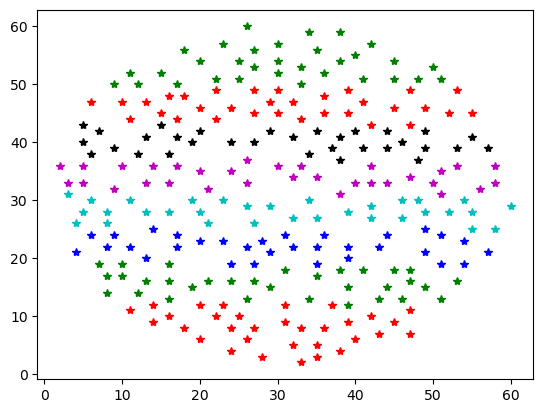

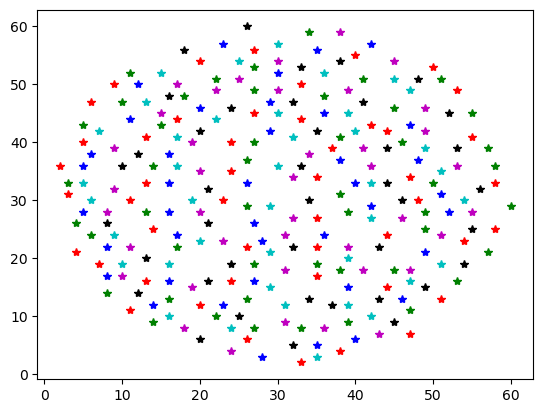

In [67]:
# Sort antennas according to the coordinates, so that we have groups of 8 antennas that we can load in parallel
# First divide the antennas into 8 groups by y coordinate.
nblocks_ants = 8
nants_per_block = nants // nblocks_ants
c = 0
c_plot = 0
# c_plot = 7
# Sort by y, then by x coordinate
sorted_y_indexes = NP.argsort(ycornerNN[:,c] * 1000 + xcornerNN[:,c])
fig = PLT.figure()
ax = fig.add_subplot(111)
clist = 'rgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmkrgbcmk'
station_by_block = NP.zeros((nblocks_ants, nants_per_block))
station_by_block_x = NP.zeros((nblocks_ants, nants_per_block))
station_by_block_sorted = []
for block in range(nblocks_ants):
    for ant in range(nants_per_block):
        # station number in each of the 8 blocks
        station_by_block[block,ant] = sorted_y_indexes[block*nants_per_block + ant]
        # x coordinate of the station in each block
        station_by_block_x[block,ant] = xcornerNN[sorted_y_indexes[block*nants_per_block + ant],c]
        ax.plot(xcornerNN[sorted_y_indexes[block*nants_per_block+ant],c_plot],ycornerNN[sorted_y_indexes[block*nants_per_block+ant],c_plot],clist[block] + '*')
    # sort station_by_block according to station_by_block_x, 
    # so that we have stations in the order they will be used in each block
    x_sort_order = NP.argsort(station_by_block_x[block,:])
    #print(x_sort_order)
    #print(station_by_block[block,:])
    #print(station_by_block[block,x_sort_order])
    station_by_block_sorted.append(list(station_by_block[block,x_sort_order]))

# Create an array with dimensions (32 groups)x(8 stations per group) which contains the station numbers.
nants_per_group = nblocks_ants
nwords_per_frame = nants // nants_per_group
group_stations = NP.zeros((nwords_per_frame,nants_per_group),dtype = NP.int32)
for group in range(nwords_per_frame):
    # Make 32 groups, with 8 antennas in each group. 
    # The 8 antennas have one drawn from each block of 32 antennas
    group_stations[group,0] = int(station_by_block_sorted[0][0])
    station_by_block_sorted[0].remove(group_stations[group,0])
    for block in range(1,nants_per_group):
        # Make sure the station doesn't have the same y coordinate as the station selected in the previous block
        group_i = 0
        for c in range(nchan):
            while (ycornerNN[group_stations[group,block-1],c] == ycornerNN[int(station_by_block_sorted[block][group_i]),c]):
                group_i += 1
        group_stations[group,block] = int(station_by_block_sorted[block][group_i])
        station_by_block_sorted[block].remove(group_stations[group,block])

# Check : every station was assigned to a group 
for s_check in range(nants):
    s_any = (group_stations == s_check)
    if (not s_any.any()):
        print(f"missing station {s_check}")
        print(group_stations)

# Check there are no duplicate y coordinates within a group.
fig = PLT.figure()
ax = fig.add_subplot(111)
for c in range(nchan):
    for group in range(nwords_per_frame):
        if len(NP.unique(ycornerNN[group_stations[group,:],c])) < nants_per_group:
            print(f'Channel {c}, Same y coordinate for group {group}')
            print(ycornerNN[group_stations[group,:],c])

# For each group find which y-coordinate FIFO the data needs to go to
y_dest = NP.zeros((nwords_per_frame,nblocks_ants,nchan))  # (32 groups) x (8 blocks) x (10 frequency channels)
for c in range(nchan):
    for group in range(nwords_per_frame):
        y_dest[group,:,c] = ycornerNN[group_stations[group,:],c]
print("y destinations:")
print(y_dest[:,:,c_plot])

# For each FIFO, which block does the data come from
# For each y-coordinate destination, find the group the data comes from:
#  (32 FIFOs) x (32 groups of stations) x (10 channels)
# Each entry is either -1 = Unused; or 0-7 = select block in the data.
FIFO_select = NP.zeros((32,32,nchan))
for c in range(nchan):
    for group in range(32):
        for fifo in range(32):
            v = NP.argwhere(y_dest[group,:,c] == fifo)
            #print("asdf")
            #print(v)
            #print(len(v))
            if (len(v) == 0):
                FIFO_select[fifo,group,c] = -1
            else:
                FIFO_select[fifo,group,c] = v[0][0]
                #print(f'fifo group c = {fifo}, {group}, {c}, v0 = {v[0][0]}')
#print('FIFO select : ')
#print(FIFO_select[10,:,:])


for group in range(nwords_per_frame):
    for block in range(nblocks_ants):
        ax.plot(xcornerNN[group_stations[group,block],c_plot],ycornerNN[group_stations[group,block],c_plot],clist[group] + '*')

        

In [68]:
# Save the data in a format that can be loaded in firmware 
#  (1) The voltage data, organised according to "group_stations", then by time sample, then frequency channel
#  (2) The fifo selection "FIFO_select", as ROM contents for the firmware
#     - 2 bits per FIFO, 32 FIFOs = 64 bits per word
#     - 32 words per frequency channel (one for each group of stations loaded),
#  (3) Jones matrices, a ROM which holds "ant_grid_wts_lol"


print(len(ant_grid_wts_lol))  # list of 10 frequency channels
print(len(ant_grid_wts_lol[0])) # list of 256 antennas
print(type(ant_grid_wts_lol[0][0])) # 2x2x1 jones matrix for each antenna and frequency channel
print(ant_grid_wts_lol[0][0].shape)
print(group_stations)
print("Order for the station data in memory : ")
print(group_stations.ravel())
# Need to save the voltage data for in the order given by NP.ravel(group_stations)
# A single sample for a single antenna will be 4 bytes : 
#   one byte per value : (pol0 real, pol0 imag, pol1 real, pol1 imaginary) 
# A full set of voltage data will be 1 kByte = 256 antennas * (4 bytes)
# The FPGA implementation will integrate all 1 kByte blocks into a single image.
# ...Add code here...


1
256
<class 'numpy.ndarray'>
(2, 2, 4)
[[235 237 255 253 251 247 249 224]
 [209 234 239 254 252 250 225 223]
 [210 236 238 241 245 246 226 222]
 [208 232 231 243 244 248 221 192]
 [178 233 214 242 229 227 195 193]
 [177 211 213 240 228 219 194 191]
 [179 212 215 230 217 220 196 190]
 [174 207 204 216 218 197 189 163]
 [173 206 203 202 201 199 188 162]
 [175 205 182 184 200 198 166 159]
 [176 180 171 183 185 186 164 157]
 [143 181 147 170 168 187 165 161]
 [141 172 148 169 167 153 155 160]
 [142 144 146 150 152 154 156 158]
 [140 145 137 149 151 134 132 126]
 [113 139 138 136 135 122 133 129]
 [112 115 117 118 119 121 131 130]
 [110 114 116  99 120  96 124 127]
 [109 104 102 100  98  97 123 125]
 [111  77 103  80  81  84  94 128]
 [107  76 101  64  82  83  95  92]
 [108  75  78  65  63  85  86  93]
 [106  67  79  47  62  60  87  91]
 [105  69  66  48  49  61  58  89]
 [ 72  68  46  34  32  51  59  90]
 [ 74  44  36  35  33  50  53  88]
 [ 73  42  37  17  18  31  52  57]
 [ 70  43  15  

## Determine the array element grouping into blocks and words for every channel

In [69]:
group_elements_allchans = array_element_grouping(xcornerNN, ycornerNN, nblocks=8)
# print(group_elements_allchans.shape)

# print(NP.abs(group_stations_allchans - group_stations).max())

NP.save(datadir+'array_element_ordering_FPGA-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.npy'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), group_elements_allchans)
print('Array element ordering saved at: '+datadir+'array_element_ordering_FPGA-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.npy'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan))

Array element ordering saved at: /mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/array_element_ordering_FPGA-64x64-grid-256-ants-1-chans.npy


## Populate the FIFOs

In [71]:
populated_FIFOs_allchans = load_FIFO(group_elements_allchans, unraveled_ind_lol, xcornerNN, ycornerNN, nFIFO=ant_ugrid.shape[0])
NP.save(datadir+'FPGA-FIFO-population-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.npy'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), populated_FIFOs_allchans)
print('FPGA FIFO population saved at: '+datadir+'FPGA-FIFO-population-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.npy'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan))

FPGA FIFO population saved at: /mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/FPGA-FIFO-population-64x64-grid-256-ants-1-chans.npy


In [72]:
ind_FIFO_conflicts = NP.where(populated_FIFOs_allchans[...,1] > -1)
print(ind_FIFO_conflicts)
print(populated_FIFOs_allchans[ind_FIFO_conflicts])

(array([0, 0, 0]), array([19, 23, 24]), array([19, 13, 43]))
[[103  77]
 [105  69]
 [ 59  51]]


In [73]:
ant_data_tafp = ant_E_dynspec['Ef'][:,group_elements_allchans[0].ravel(),:,:].to('Jy(1/2)').value # reordered based on station grouping index
ant_data_ftap = NP.moveaxis(ant_data_tafp, -2, 0) # slowest varying -> frequency -> time -> antennas -> pol -> Fastest varying
print(ant_data_tafp.shape)
print(ant_data_ftap.shape)

(100000, 256, 1, 2)
(1, 100000, 256, 2)


In [75]:
realimag = NP.concatenate((ant_data_ftap.real[...,NP.newaxis],ant_data_ftap.imag[...,NP.newaxis]), axis=-1)
maxabsdata = NP.abs(realimag).max()
print(realimag.min(), realimag.max(), maxabsdata)

-13.274726765639475 13.64362667013847 13.64362667013847


In [29]:
# realimag_scaled = mathops.minmax_scaler(realimag-eps, low=-nlevs//2, high=nlevs//2-eps)
# print(realimag_scaled.min(), realimag_scaled.max())
# print(realimag_scaled[0,0,0,...])
# realimag_scaled = NP.round(realimag_scaled).astype(NP.int8)
# print(realimag_scaled[0,0,0,...])
# print(realimag_scaled.min(), realimag_scaled.max())

In [76]:
eps = 1e-8 # A small offset value (just to move the bin boundary away from max or min)
nbits = 8
nlevs = 2**nbits
bins = NP.linspace(-maxabsdata, maxabsdata+eps, num=nlevs, endpoint=True)
realimagbinned = NP.searchsorted(bins, realimag, side='right') - nlevs//2
realimagbinned = realimagbinned.astype(NP.int8)

# realbinned = NP.searchsorted(bins, ant_data_ftap.real, side='right') - nlevs//2
# imagbinned = NP.searchsorted(bins, ant_data_ftap.imag, side='right') - nlevs//2
# realbinned = realbinned.astype(NP.int8)
# imagbinned = imagbinned.astype(NP.int8)

print(bins)
print(bins.shape)
print(ant_data_ftap.real.min(), ant_data_ftap.real.max())
print(ant_data_ftap.imag.min(), ant_data_ftap.imag.max())
print(realimag.min(), realimag.max())
print(realimagbinned[...,0].min(), realimagbinned[...,0].max())
print(realimagbinned[...,1].min(), realimagbinned[...,1].max())
# print(imagbinned.min(), imagbinned.max())
print(realimagbinned.shape)
print(realimagbinned.dtype)
print(realimagbinned.nbytes)

[-13.64362667 -13.53661783 -13.429609   -13.32260016 -13.21559132
 -13.10858249 -13.00157365 -12.89456481 -12.78755598 -12.68054714
 -12.5735383  -12.46652947 -12.35952063 -12.25251179 -12.14550296
 -12.03849412 -11.93148528 -11.82447645 -11.71746761 -11.61045877
 -11.50344994 -11.3964411  -11.28943226 -11.18242343 -11.07541459
 -10.96840575 -10.86139692 -10.75438808 -10.64737924 -10.54037041
 -10.43336157 -10.32635273 -10.2193439  -10.11233506 -10.00532622
  -9.89831739  -9.79130855  -9.68429971  -9.57729088  -9.47028204
  -9.3632732   -9.25626437  -9.14925553  -9.04224669  -8.93523786
  -8.82822902  -8.72122018  -8.61421135  -8.50720251  -8.40019367
  -8.29318484  -8.186176    -8.07916716  -7.97215833  -7.86514949
  -7.75814065  -7.65113182  -7.54412298  -7.43711414  -7.33010531
  -7.22309647  -7.11608763  -7.0090788   -6.90206996  -6.79506112
  -6.68805229  -6.58104345  -6.47403461  -6.36702578  -6.26001694
  -6.1530081   -6.04599927  -5.93899043  -5.83198159  -5.72497276
  -5.61796

In [77]:
realimagbinned.tofile(datadir+'epic-test-data-{0:0d}-runs-{1:0d}x{2:0d}-grid-{3:0d}-ants-{4:0d}-chans.dat'.format(nruns, ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan))
print('Binary data saved at: '+datadir+'epic-test-data-{0:0d}-runs-{1:0d}x{2:0d}-grid-{3:0d}-ants-{4:0d}-chans.dat'.format(nruns, ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan))
NP.save(datadir+'aavs_station_element_fpga_ordering_32x8.npy', group_stations)

Binary data saved at: /mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/epic-test-data-100000-runs-64x64-grid-256-ants-1-chans.dat


In [52]:
# Jones Matrices:
#  We need initialisation data for 64 block rams.
#  Each block RAM contains all the Jones data for a single row of the grid.
#  Each block ram contains 64 words, where each word is a complete Jones matrix, for one column in the grid.
#  One Jones matrix = 4 complex values = 8 bytes (1 byte real + 1 byte imaginary per value)
#  If there is no contribution from any of the antennas at a particular grid point, then the
#  corresponding Jones matrix should be 0.
#  Format:
#   In a real system this data would be written by control software, and updated as the array is calibrated.
#   For a demo, just build the values into the firmware image.
#   To do this, put the Jones data in 64 text files, where each file is 64 lines, with a Jones matrix on each line.
#   Jones data for grid point (x,y) is at line "y" in file "x"
#   Each line in a file is written as a string of hexadecimal digits, e.g.
#   0123456789ABCDEF
#   which represents a Jones Matrix : 
#    [(0xEF + 0xCD*i) (0xAB + 0x89 * i)]  
#    [(0x67 + 0x45*i) (0x23 + 0x12 * i)]
#   using 8-bit signed values (so 0xFF = -1)
#  ...Add code here...


int8


In [20]:
# fig = PLT.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.imshow(valgrid)

In [21]:
# indNN_L1_raveled = nearest_nghbrs(NP.column_stack([xlocs, ylocs]), xg, yg, distUL, dist_norm=1)
# indNN_L2_raveled = nearest_nghbrs(NP.column_stack([xlocs, ylocs]), xg, yg, distUL, dist_norm=2)
# print(indNN_L2_raveled)

In [22]:
# indNN_L1 = [NP.unravel_index(indNN_L1_raveled[i], xg.shape) for i in range(xlocs.size)]
# indNN_L2 = [NP.unravel_index(indNN_L2_raveled[i], xg.shape) for i in range(xlocs.size)]


In [23]:
# print(indNN_L1[0])
# print('-----------')
# print(indNN_L2)

In [24]:
# layered_L1_footprint = NP.zeros((xlocs.size,)+xg.shape, dtype=int)
# layered_L2_footprint = NP.zeros((xlocs.size,)+xg.shape, dtype=int)
# for i in range(xlocs.size):
#     fp1 = NP.zeros(xg.shape, dtype=int)
#     fp1[indNN_L1[i]] = 1
#     fp2 = NP.zeros(xg.shape, dtype=int)
#     fp2[indNN_L2[i]] = 1
#     layered_L1_footprint[i] = NP.copy(fp1)
#     layered_L2_footprint[i] = NP.copy(fp2)
# net_L1_footprint = NP.sum(layered_L1_footprint, axis=0)
# net_L2_footprint = NP.sum(layered_L2_footprint, axis=0)

In [25]:
# fig = PLT.figure(figsize=(4,4))
# ax = fig.add_subplot(111)
# ax.imshow(net_L2_footprint)

In [26]:
# print(indNN_L2_raveled)
# indNN_L2_raveled_new = LKP.find_NN(NP.column_stack([xlocs, ylocs]), NP.column_stack([xg.ravel(), yg.ravel()]), distance_ULIM=distUL)
# # print(indNN_L2_raveled_new[0])
# indNN_L2_new = [NP.unravel_index(indNN_L2_raveled_new[0][i], xg.shape) for i in range(xlocs.size)]